#### Import Library for Sales Forecast LSTM

In [89]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Flatten, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K

In [90]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

#### GlobalSalesForecaster Class

In [96]:
class GlobalSalesForecaster:
    def __init__(self, look_back=6, batch_size=4, epochs=100):
        self.look_back = look_back
        self.batch_size = batch_size
        self.epochs = epochs
        self.model = None
        self.scalers = {}      
        self.le_root = LabelEncoder()
        self.df_global = None 

    def preprocess_and_merge_history(self, df_raw, df_ref=None):
        df = df_raw.copy()
        df['period'] = pd.to_datetime(df['period'])
        
        if df_ref is not None and 'model_reference' not in df.columns:
            df = df.merge(df_ref[['model', 'model_reference']], on='model', how='left')
        df['model_reference'] = df['model_reference'].fillna(df['model'])
        
        parent_map = df.set_index('model')['model_reference'].to_dict()
        def find_root(m):
            curr = m
            visited = set()
            while True:
                if curr in visited: return curr
                visited.add(curr)
                parent = parent_map.get(curr, curr)
                if parent == curr or pd.isna(parent): return curr
                curr = parent
        
        df['root_ref'] = df['model'].apply(find_root)
        self.df_global = df.groupby(['period', 'root_ref'])['model_qty'].sum().reset_index()
        
        valid_roots = self.df_global['root_ref'].value_counts()[self.df_global['root_ref'].value_counts() >= 18].index
        self.df_global = self.df_global[self.df_global['root_ref'].isin(valid_roots)]
        self.le_root.fit(self.df_global['root_ref'])
        return self.df_global

    def generate_sequences(self):
        X_list, y_list, r_idx, m_idx, weights = [], [], [], [], []
        for root_name, group in self.df_global.groupby('root_ref'):
            group = group.sort_values('period').set_index('period').resample('MS').agg({'model_qty': 'sum'}).reset_index()
            qty = group['model_qty'].values.astype(float)
            
            if len(qty) < (self.look_back + 1): continue
            
            # Log Scaling untuk stabilitas varians (GitHub style)
            qty_log = np.log1p(qty) 
            diff = qty_log[1:] - qty_log[:-1]
            
            sc = StandardScaler()
            diff_scaled = sc.fit_transform(diff.reshape(-1, 1)).flatten()
            self.scalers[root_name] = sc
            
            r_id = self.le_root.transform([root_name])[0]
            months = group['period'].dt.month.values - 1

            for i in range(len(diff_scaled) - self.look_back):
                X_list.append(diff_scaled[i : i + self.look_back])
                y_list.append(diff_scaled[i + self.look_back])
                r_idx.append(r_id)
                m_idx.append(months[i + self.look_back + 1] if (i + self.look_back + 1) < len(months) else months[-1])
                weights.append(1.0)
                    
        return np.array(X_list).reshape(-1, self.look_back, 1), np.array(y_list), np.array(r_idx), np.array(m_idx), np.array(weights)

    def build_model_variant(self, variant='deep_lstm'):
        input_seq = Input(shape=(self.look_back, 1), name='seq_in')
        input_root = Input(shape=(1,), name='root_in')
        input_month = Input(shape=(1,), name='month_in')
        
        if variant == 'attention':
            from tensorflow.keras.layers import MultiHeadAttention, Add
            x = Bidirectional(LSTM(64, return_sequences=True))(input_seq)
            attn = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
            x = Add()([x, attn])
            x = LSTM(64, return_sequences=False)(x)
        else: # deep_lstm (GitHub Style)
            x = LSTM(96, return_sequences=True, activation='tanh')(input_seq)
            x = BatchNormalization()(x)
            x = LSTM(96, return_sequences=True, activation='tanh')(x)
            x = LSTM(96, return_sequences=False, activation='tanh')(x)
            x = BatchNormalization()(x)

        x = Dropout(0.25)(x)
        emb_r = Flatten()(Embedding(len(self.le_root.classes_) + 1, 32)(input_root))
        emb_m = Flatten()(Embedding(12, 16)(input_month))
        
        concat = Concatenate()([x, emb_r, emb_m])
        x = Dense(64, activation='relu')(concat)
        out = Dense(1, activation='linear')(x)
        
        self.model = Model(inputs=[input_seq, input_root, input_month], outputs=out)
        self.model.compile(optimizer=Adam(learning_rate=0.001), loss=root_mean_squared_error, metrics=['mae'])
        return self.model

    def train(self, X, y, r_idx, m_idx, weights):
        # Tambahan EarlyStopping & ReduceLR agar tidak overfitting
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-5)
        ]
        history = self.model.fit(
            [X, r_idx, m_idx], y,
            validation_split=0.2,
            epochs=self.epochs,
            batch_size=self.batch_size,
            shuffle=True,
            callbacks=callbacks,
            verbose=1
        )
        return history

    def forecast_2026(self, months_ahead=12):
        results = []
        for root_name, group in self.df_global.groupby('root_ref'):
            sc = self.scalers[root_name]
            qty_hist = group.sort_values('period')['model_qty'].values.astype(float)
            
            qty_log = np.log1p(qty_hist)
            diff_scaled = sc.transform((qty_log[1:] - qty_log[:-1]).reshape(-1, 1)).flatten().tolist()
            
            current_seq = diff_scaled[-self.look_back:]
            last_qty_log = qty_log[-1]
            root_id = self.le_root.transform([root_name])[0]
            
            preds_qty = []
            for m in range(1, months_ahead + 1):
                inp = np.array(current_seq).reshape(1, self.look_back, 1)
                month_id = (group['period'].dt.month.iloc[-1] + m - 1) % 12
                
                p_scaled = self.model.predict([inp, np.array([root_id]), np.array([month_id])], verbose=0)[0][0]
                p_diff = sc.inverse_transform(np.array([[p_scaled]]))[0, 0]
                
                next_qty_log = last_qty_log + p_diff
                preds_qty.append(np.expm1(next_qty_log))
                
                current_seq.pop(0)
                current_seq.append(p_scaled)
                last_qty_log = next_qty_log
            
            res = {'Root_Family': root_name, 'Model_Name': root_name}
            months_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'Mei', 'Jun', 'Jul', 'Agu', 'Sep', 'Okt', 'Nov', 'Des']
            for i, m_name in enumerate(months_labels):
                res[m_name] = preds_qty[i]
            res['Total_2026'] = sum(preds_qty)
            results.append(res)
        return pd.DataFrame(results)

In [95]:
class EnsembleForecaster:
    def __init__(self, look_back=6):
        self.forecasters = {}
        self.weights = {}
        self.look_back = look_back
    
    def train_ensemble(self, df_raw, df_ref, variants=['deep_lstm', 'attention']):
        for variant in variants:
            print(f"\n>>> Training Variant: {variant}")
            fc = GlobalSalesForecaster(look_back=self.look_back, batch_size=4, epochs=100)
            fc.preprocess_and_merge_history(df_raw, df_ref)
            X, y, r_idx, m_idx, weights = fc.generate_sequences()
            
            fc.build_model_variant(variant)
            history = fc.train(X, y, r_idx, m_idx, weights)
            
            val_mae = history.history['val_mae'][-1]
            self.weights[variant] = 1.0 / (val_mae + 1e-6)
            self.forecasters[variant] = fc
            
        total_w = sum(self.weights.values())
        self.weights = {k: v/total_w for k, v in self.weights.items()}

    def forecast_ensemble(self, months_ahead=12):
        final_df = None
        for variant, fc in self.forecasters.items():
            df_v = fc.forecast_2026(months_ahead)
            w = self.weights[variant]
            if final_df is None:
                final_df = df_v.copy()
                num_cols = df_v.select_dtypes(include=[np.number]).columns
                for col in num_cols: final_df[col] = df_v[col] * w
            else:
                num_cols = df_v.select_dtypes(include=[np.number]).columns
                for col in num_cols: final_df[col] += df_v[col] * w
        
        for col in num_cols: final_df[col] = final_df[col].round().astype(int)
        return final_df

#### Load Dataset dan Configuration

d:\Magang\db\connection_SQL.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df1 = pd.read_sql(query1, conn)
d:\Magang\db\connection_SQL.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(query2, conn)
d:\Magang\db\connection_SQL.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df3 = pd.read_sql(query3, conn)



>>> Training Variant: deep_lstm
Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.9623 - mae: 0.8175 - val_loss: 0.9423 - val_mae: 0.8196 - learning_rate: 0.0010
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.9144 - mae: 0.7724 - val_loss: 0.9394 - val_mae: 0.8160 - learning_rate: 0.0010
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.8404 - mae: 0.7136 - val_loss: 0.8669 - val_mae: 0.7508 - learning_rate: 0.0010
Epoch 4/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.8066 - mae: 0.6843 - val_loss: 0.8300 - val_mae: 0.7001 - learning_rate: 0.0010
Epoch 5/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.7969 - mae: 0.6757 - val_loss: 0.8300 - val_mae: 0.7178 - learning_rate: 0.0010
Epoch 6/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.8054 - mae: 0.6820 - val_loss: 0.9229 - val_mae: 0.7956 - learning_rate: 0.0010
Epoch 7/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.7766 - mae: 0.6547 - val_loss: 0.8066 

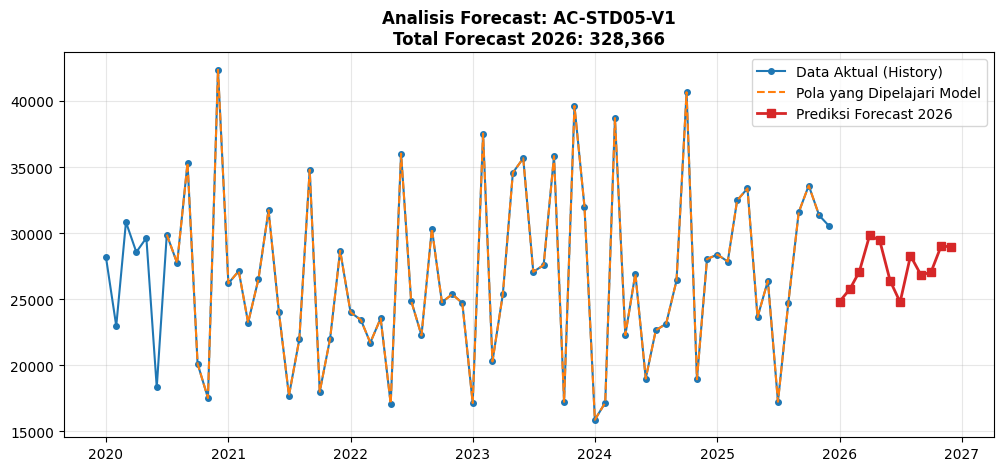

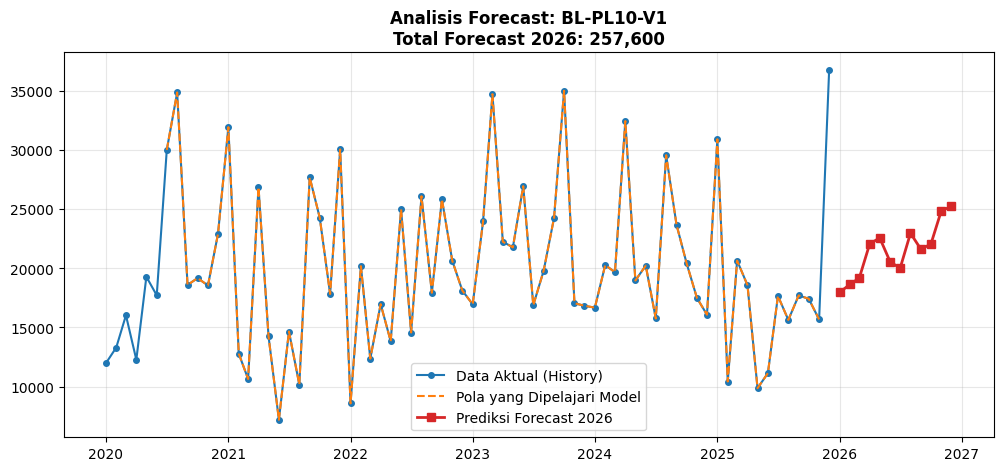

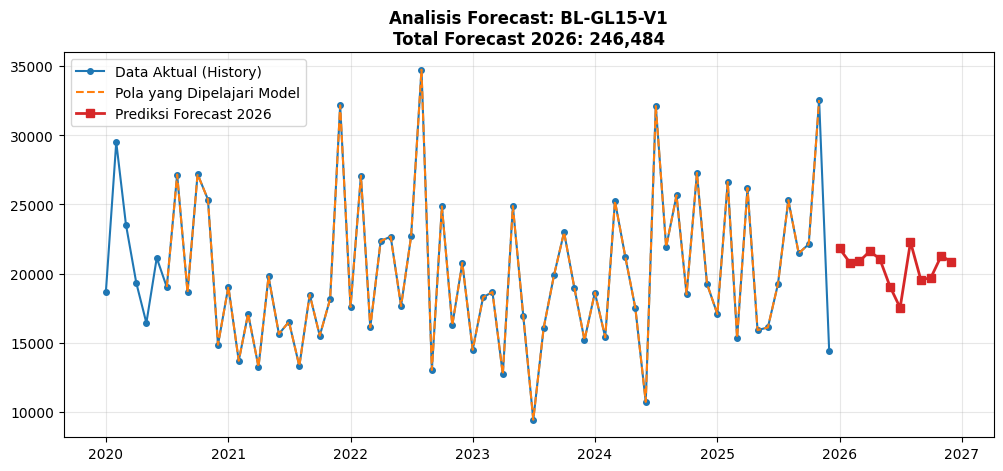

In [97]:
def load_dataset_local():
    try:
        from db.connection_SQL import getData
        df_hist, _, df_ref = getData()
        return df_hist, df_ref
    except:
        return pd.read_csv('sales_history.csv'), None

df_raw, df_ref = load_dataset_local()

if df_raw is not None:
    ensemble = EnsembleForecaster(look_back=6)
    ensemble.train_ensemble(df_raw, df_ref, variants=['deep_lstm', 'attention'])
    df_result = ensemble.forecast_ensemble(months_ahead=12)
    
    # Save & Visualize
    df_result.to_excel("Forecast_Result_Ensemble_2026.xlsx", index=False)
    
    # Visualisasi menggunakan salah satu varian forecaster (misal: deep_lstm)
    plot_forecast_visualization(ensemble.forecasters['deep_lstm'], df_result, top_n=3)

#### Evaluate Models (Comparison)

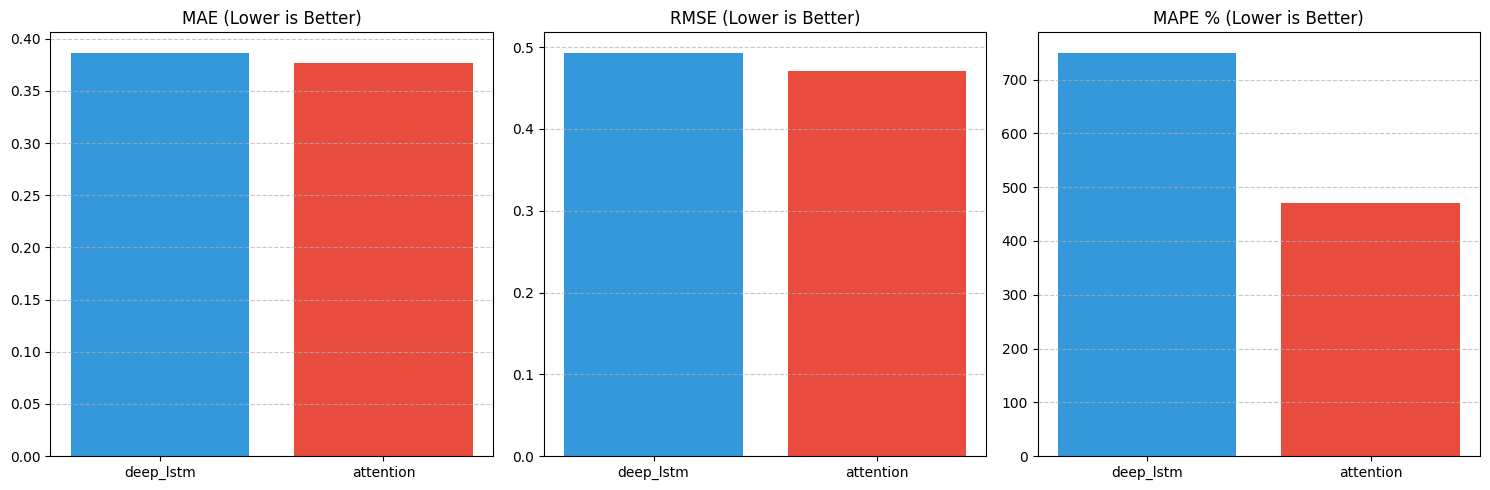

In [98]:
import matplotlib.pyplot as plt

def evaluate_variant_metrics(forecaster, X_test, y_test, r_idx_test, m_idx_test, variant_name='model'):
    try:
        y_pred_scaled = forecaster.model.predict([X_test, r_idx_test, m_idx_test], verbose=0).flatten()
        
        y_pred = np.zeros_like(y_pred_scaled)
        y_true = np.zeros_like(y_pred_scaled)
        for i, (ps, ts, rid) in enumerate(zip(y_pred_scaled, y_test, r_idx_test)):
            root_name = forecaster.le_root.inverse_transform([rid])[0]
            sc = forecaster.scalers[root_name]
            y_pred[i] = sc.inverse_transform(np.array([[ps]]))[0, 0]
            y_true[i] = sc.inverse_transform(np.array([[ts]]))[0, 0]
        
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
        mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100
        
        return {'mae': mae, 'rmse': rmse, 'mape': mape}
    except Exception as e:
        print(f"[ERROR] Eval {variant_name}: {e}")
        return None
    
eval_summary = {}
for var_name, fc in ensemble.forecasters.items():
    X, y, r_idx, m_idx, _ = fc.generate_sequences()
    split_idx = int(len(X) * 0.8)
    
    metrics = evaluate_variant_metrics(
        fc, X[split_idx:], y[split_idx:], r_idx[split_idx:], m_idx[split_idx:], variant_name=var_name
    )
    if metrics:
        eval_summary[var_name] = metrics

if eval_summary:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    metrics_list = ['mae', 'rmse', 'mape']
    titles = ['MAE (Lower is Better)', 'RMSE (Lower is Better)', 'MAPE % (Lower is Better)']
    
    for i, m in enumerate(metrics_list):
        labels = list(eval_summary.keys())
        values = [eval_summary[k][m] for k in labels]
        axes[i].bar(labels, values, color=['#3498db', '#e74c3c'])
        axes[i].set_title(titles[i])
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

#### Visualisasi Forecast Results

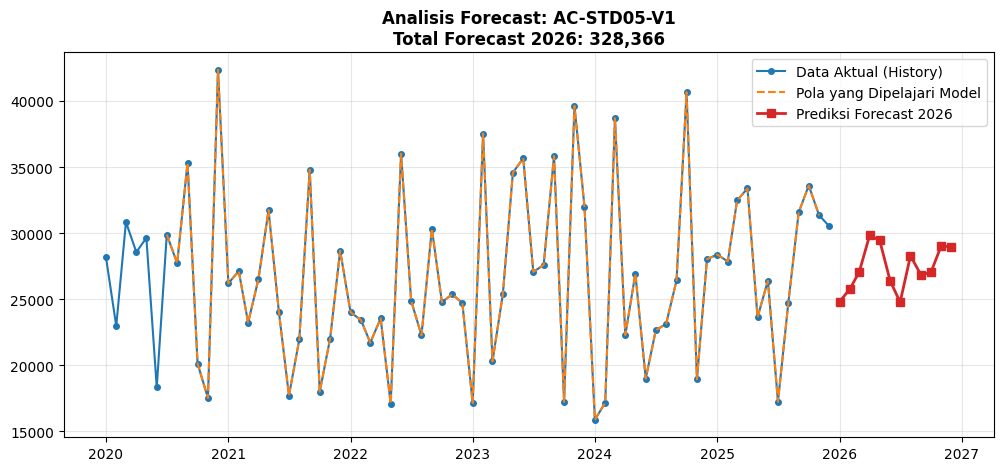

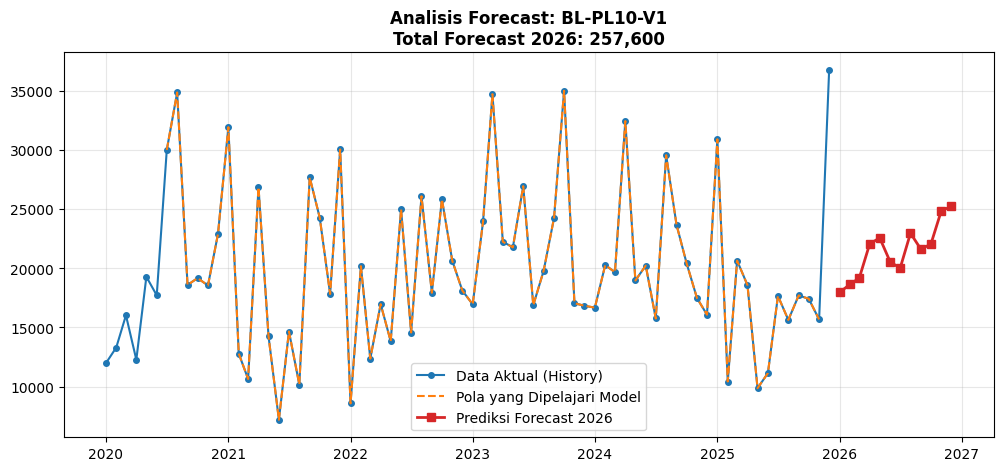

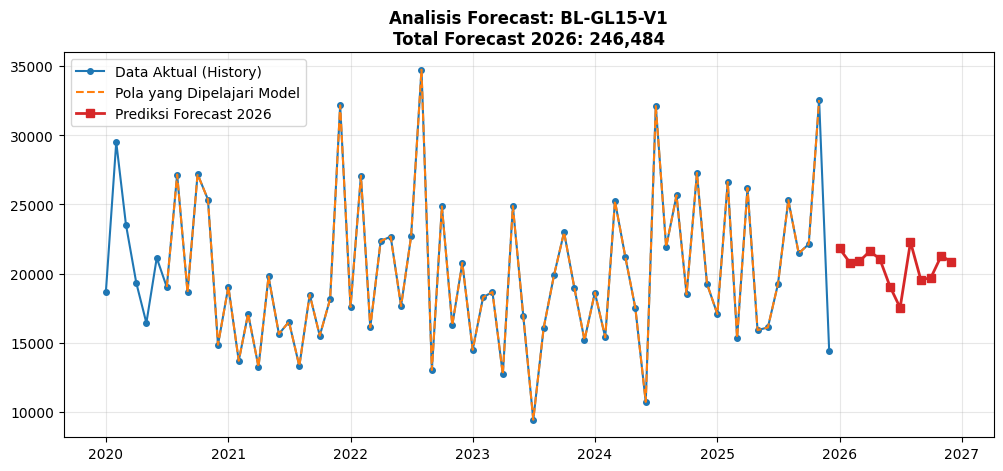

In [99]:
def plot_forecast_visualization(forecaster_obj, df_result, top_n=3):
    top_models = df_result.sort_values('Total_2026', ascending=False).head(top_n)
    
    for _, row in top_models.iterrows():
        root_name = row['Root_Family']
        model_name = row['Model_Name']
        
        try:
            scaler = forecaster_obj.scalers[root_name]
            subset = forecaster_obj.df_global[forecaster_obj.df_global['root_ref'] == root_name].sort_values('period')
            
            dates_hist = subset['period'].values
            qty_hist = subset['model_qty'].values.astype(float)
            pred_values = [np.nan] * forecaster_obj.look_back
            diff = qty_hist[1:] - qty_hist[:-1]
            diff_scaled = scaler.transform(diff.reshape(-1, 1)).flatten()
            
            for i in range(len(diff_scaled) - forecaster_obj.look_back):
                seq = diff_scaled[i : i + forecaster_obj.look_back].reshape(1, forecaster_obj.look_back, 1)
                r_id = np.array([forecaster_obj.le_root.transform([root_name])[0]])
                m_id = np.array([pd.to_datetime(dates_hist[i + forecaster_obj.look_back + 1]).month - 1])
                
                p_scaled = forecaster_obj.model.predict([seq, r_id, m_id], verbose=0)[0][0]
                p_diff = scaler.inverse_transform(np.array([[p_scaled]]))[0, 0]
                pred_values.append(qty_hist[i + forecaster_obj.look_back] + p_diff)
            cols_bulan = ['Jan', 'Feb', 'Mar', 'Apr', 'Mei', 'Jun', 'Jul', 'Agu', 'Sep', 'Okt', 'Nov', 'Des']
            forecast_vals = [row[m] for m in cols_bulan]
            dates_2026 = pd.date_range(start=dates_hist[-1], periods=13, freq='MS')[1:]
            plt.figure(figsize=(12, 5))
            plt.plot(dates_hist, qty_hist, label='Data Aktual (History)', color='#1f77b4', marker='o', markersize=4)
            plt.plot(dates_hist[:len(pred_values)], pred_values, label='Pola yang Dipelajari Model', color='#ff7f0e', linestyle='--')
            plt.plot(dates_2026, forecast_vals, label='Prediksi Forecast 2026', color='#d62728', marker='s', linewidth=2)
            
            plt.title(f"Analisis Forecast: {model_name}\nTotal Forecast 2026: {int(row['Total_2026']):,}", fontweight='bold')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
            
        except Exception as e:
            print(f"Gagal visualisasi {model_name}: {e}")
plot_forecast_visualization(ensemble.forecasters['attention'], df_result, top_n=3)